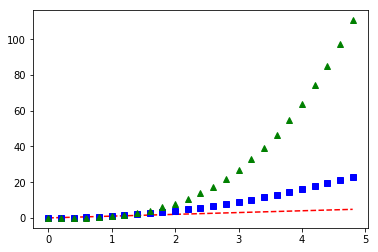

In [8]:
import numpy as np
import matplotlib.pyplot as plt


# evenly sampled time at 200ms intervals
t = np.arange(0., 5., 0.2)

# red dashes, blue squares and green triangles
plt.plot(t, t, 'r--', t, t**2, 'bs', t, t**3, 'g^')
plt.show()

In [3]:
%matplotlib inline

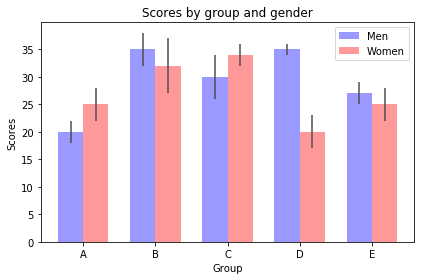

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from collections import namedtuple


n_groups = 5

means_men = (20, 35, 30, 35, 27)
std_men = (2, 3, 4, 1, 2)

means_women = (25, 32, 34, 20, 25)
std_women = (3, 5, 2, 3, 3)

fig, ax = plt.subplots()

index = np.arange(n_groups)
bar_width = 0.35

opacity = 0.4
error_config = {'ecolor': '0.3'}

rects1 = ax.bar(index, means_men, bar_width,
                alpha=opacity, color='b',
                yerr=std_men, error_kw=error_config,
                label='Men')

rects2 = ax.bar(index + bar_width, means_women, bar_width,
                alpha=opacity, color='r',
                yerr=std_women, error_kw=error_config,
                label='Women')

ax.set_xlabel('Group')
ax.set_ylabel('Scores')
ax.set_title('Scores by group and gender')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(('A', 'B', 'C', 'D', 'E'))
ax.legend()

fig.tight_layout()
plt.show()

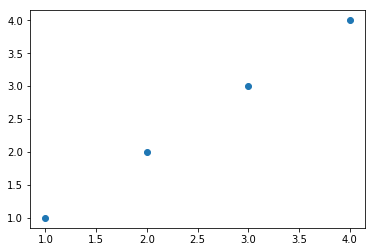

In [6]:
from matplotlib import pyplot as plt

x = [1, 2, 3, 4]
y = [1, 2, 3, 4]

plt.plot(x, y, 'o')
plt.show()

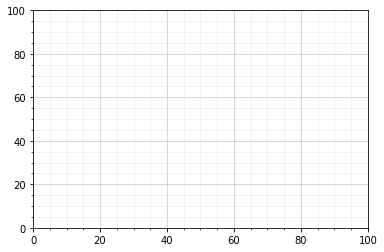

In [ ]:
import numpy as np
import matplotlib.pyplot as plt



fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# Major ticks every 20, minor ticks every 5
major_ticks = np.arange(0, 101, 20)
minor_ticks = np.arange(0, 101, 5)

ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)

# And a corresponding grid
ax.grid(which='both')

# Or if you want different settings for the grids:
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5)

plt.show()

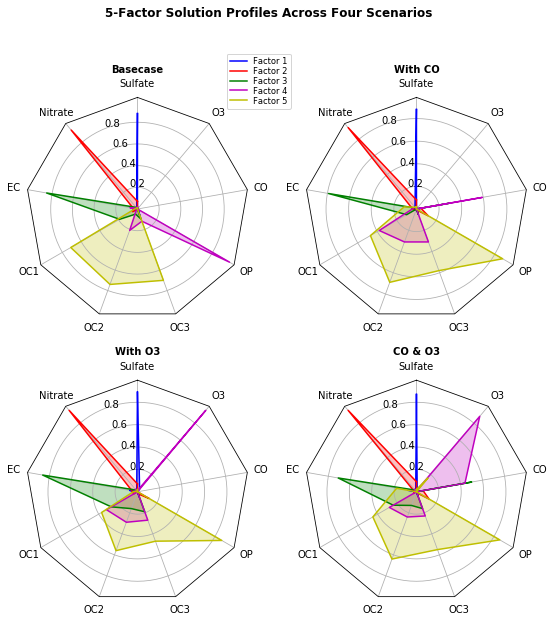

In [3]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib.spines import Spine
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection

# Uncomment following line if:
# - you're using Jupyter
# - want to display charts inline
#
%matplotlib inline

def radar_factory(num_vars, frame='circle'):
    """Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle' | 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    def draw_poly_patch(self):
        # rotate theta such that the first axis is at the top
        verts = unit_poly_verts(theta + np.pi / 2)
        return plt.Polygon(verts, closed=True, edgecolor='k')

    def draw_circle_patch(self):
        # unit circle centered on (0.5, 0.5)
        return plt.Circle((0.5, 0.5), 0.5)

    patch_dict = {'polygon': draw_poly_patch, 'circle': draw_circle_patch}
    if frame not in patch_dict:
        raise ValueError('unknown value for `frame`: %s' % frame)

    class RadarAxes(PolarAxes):

        name = 'radar'
        # use 1 line segment to connect specified points
        RESOLUTION = 1
        # define draw_frame method
        draw_patch = patch_dict[frame]

        def __init__(self, *args, **kwargs):
            super(RadarAxes, self).__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, **kwargs):
            """Override fill so that line is closed by default"""
            closed = kwargs.pop('closed', True)
            return super(RadarAxes, self).fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super(RadarAxes, self).plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.concatenate((x, [x[0]]))
                y = np.concatenate((y, [y[0]]))
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            return self.draw_patch()

        def _gen_axes_spines(self):
            if frame == 'circle':
                return PolarAxes._gen_axes_spines(self)
            # The following is a hack to get the spines (i.e. the axes frame)
            # to draw correctly for a polygon frame.

            # spine_type must be 'left', 'right', 'top', 'bottom', or `circle`.
            spine_type = 'circle'
            verts = unit_poly_verts(theta + np.pi / 2)
            # close off polygon by repeating first vertex
            verts.append(verts[0])
            path = Path(verts)

            spine = Spine(self, spine_type, path)
            spine.set_transform(self.transAxes)
            return {'polar': spine}

    register_projection(RadarAxes)
    return theta


def unit_poly_verts(theta):
    """Return vertices of polygon for subplot axes.

    This polygon is circumscribed by a unit circle centered at (0.5, 0.5)
    """
    x0, y0, r = [0.5] * 3
    verts = [(r*np.cos(t) + x0, r*np.sin(t) + y0) for t in theta]
    return verts


def example_data():
    # The following data is from the Denver Aerosol Sources and Health study.
    # See  doi:10.1016/j.atmosenv.2008.12.017
    #
    # The data are pollution source profile estimates for five modeled
    # pollution sources (e.g., cars, wood-burning, etc) that emit 7-9 chemical
    # species. The radar charts are experimented with here to see if we can
    # nicely visualize how the modeled source profiles change across four
    # scenarios:
    #  1) No gas-phase species present, just seven particulate counts on
    #     Sulfate
    #     Nitrate
    #     Elemental Carbon (EC)
    #     Organic Carbon fraction 1 (OC)
    #     Organic Carbon fraction 2 (OC2)
    #     Organic Carbon fraction 3 (OC3)
    #     Pyrolized Organic Carbon (OP)
    #  2)Inclusion of gas-phase specie carbon monoxide (CO)
    #  3)Inclusion of gas-phase specie ozone (O3).
    #  4)Inclusion of both gas-phase species is present...
    data = [
        ['Sulfate', 'Nitrate', 'EC', 'OC1', 'OC2', 'OC3', 'OP', 'CO', 'O3'],
        ('Basecase', [
            [0.88, 0.01, 0.03, 0.03, 0.00, 0.06, 0.01, 0.00, 0.00],
            [0.07, 0.95, 0.04, 0.05, 0.00, 0.02, 0.01, 0.00, 0.00],
            [0.01, 0.02, 0.85, 0.19, 0.05, 0.10, 0.00, 0.00, 0.00],
            [0.02, 0.01, 0.07, 0.01, 0.21, 0.12, 0.98, 0.00, 0.00],
            [0.01, 0.01, 0.02, 0.71, 0.74, 0.70, 0.00, 0.00, 0.00]]),
        ('With CO', [
            [0.88, 0.02, 0.02, 0.02, 0.00, 0.05, 0.00, 0.05, 0.00],
            [0.08, 0.94, 0.04, 0.02, 0.00, 0.01, 0.12, 0.04, 0.00],
            [0.01, 0.01, 0.79, 0.10, 0.00, 0.05, 0.00, 0.31, 0.00],
            [0.00, 0.02, 0.03, 0.38, 0.31, 0.31, 0.00, 0.59, 0.00],
            [0.02, 0.02, 0.11, 0.47, 0.69, 0.58, 0.88, 0.00, 0.00]]),
        ('With O3', [
            [0.89, 0.01, 0.07, 0.00, 0.00, 0.05, 0.00, 0.00, 0.03],
            [0.07, 0.95, 0.05, 0.04, 0.00, 0.02, 0.12, 0.00, 0.00],
            [0.01, 0.02, 0.86, 0.27, 0.16, 0.19, 0.00, 0.00, 0.00],
            [0.01, 0.03, 0.00, 0.32, 0.29, 0.27, 0.00, 0.00, 0.95],
            [0.02, 0.00, 0.03, 0.37, 0.56, 0.47, 0.87, 0.00, 0.00]]),
        ('CO & O3', [
            [0.87, 0.01, 0.08, 0.00, 0.00, 0.04, 0.00, 0.00, 0.01],
            [0.09, 0.95, 0.02, 0.03, 0.00, 0.01, 0.13, 0.06, 0.00],
            [0.01, 0.02, 0.71, 0.24, 0.13, 0.16, 0.00, 0.50, 0.00],
            [0.01, 0.03, 0.00, 0.28, 0.24, 0.23, 0.00, 0.44, 0.88],
            [0.02, 0.00, 0.18, 0.45, 0.64, 0.55, 0.86, 0.00, 0.16]])
    ]
    return data


if __name__ == '__main__':
    N = 9
    theta = radar_factory(N, frame='polygon')

    data = example_data()
    spoke_labels = data.pop(0)

    fig, axes = plt.subplots(figsize=(9, 9), nrows=2, ncols=2,
                             subplot_kw=dict(projection='radar'))
    fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)

    colors = ['b', 'r', 'g', 'm', 'y']
    # Plot the four cases from the example data on separate axes
    for ax, (title, case_data) in zip(axes.flatten(), data):
        ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
        ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.1),
                     horizontalalignment='center', verticalalignment='center')
        for d, color in zip(case_data, colors):
            ax.plot(theta, d, color=color)
            ax.fill(theta, d, facecolor=color, alpha=0.25)
        ax.set_varlabels(spoke_labels)

    # add legend relative to top-left plot
    ax = axes[0, 0]
    labels = ('Factor 1', 'Factor 2', 'Factor 3', 'Factor 4', 'Factor 5')
    legend = ax.legend(labels, loc=(0.9, .95),
                       labelspacing=0.1, fontsize='small')

    fig.text(0.5, 0.965, '5-Factor Solution Profiles Across Four Scenarios',
             horizontalalignment='center', color='black', weight='bold',
             size='large')

    plt.show()

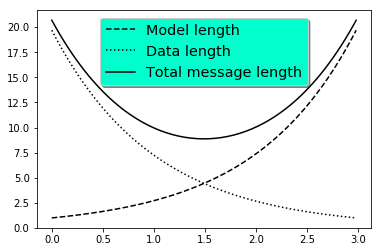

In [4]:
import numpy as np
import matplotlib.pyplot as plt


# Make some fake data.
a = b = np.arange(0, 3, .02)
c = np.exp(a)
d = c[::-1]

# Create plots with pre-defined labels.
fig, ax = plt.subplots()
ax.plot(a, c, 'k--', label='Model length')
ax.plot(a, d, 'k:', label='Data length')
ax.plot(a, c + d, 'k', label='Total message length')

legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')

# Put a nicer background color on the legend.
legend.get_frame().set_facecolor('#00FFCC')

plt.show()

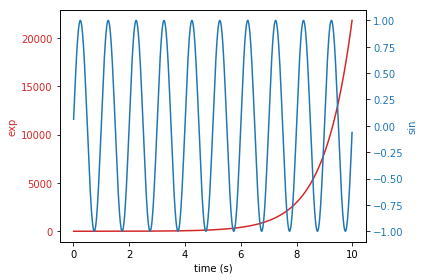

In [5]:
import numpy as np
import matplotlib.pyplot as plt


# Uncomment following line if:
# - you're using Jupyter
# - want to display charts inline
#
%matplotlib inline


# Create some mock data
t = np.arange(0.01, 10.0, 0.01)
data1 = np.exp(t)
data2 = np.sin(2 * np.pi * t)

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('exp', color=color)
ax1.plot(t, data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('sin', color=color)  # we already handled the x-label with ax1
ax2.plot(t, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

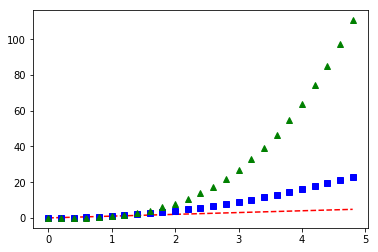

In [6]:
import numpy as np
import matplotlib.pyplot as plt


# Uncomment following line if:
# - you're using Jupyter
# - want to display charts inline
#
%matplotlib inline


# evenly sampled time at 200ms intervals
t = np.arange(0., 5., 0.2)

# red dashes, blue squares and green triangles
plt.plot(t, t, 'r--', t, t**2, 'bs', t, t**3, 'g^')
plt.show()

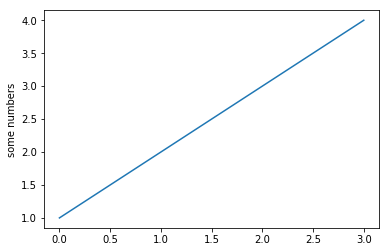

In [7]:
import matplotlib.pyplot as plt


# Uncomment following line if:
# - you're using Jupyter
# - want to display charts inline
#
%matplotlib inline


plt.plot([1,2,3,4])
plt.ylabel('some numbers')
plt.show()

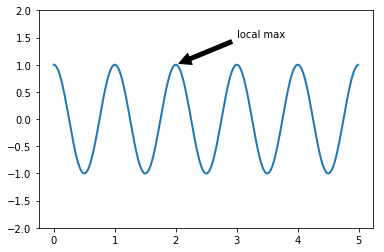

In [8]:
import numpy as np
import matplotlib.pyplot as plt


# Uncomment following line if:
# - you're using Jupyter
# - want to display charts inline
#
%matplotlib inline


fig, ax = plt.subplots()

t = np.arange(0.0, 5.0, 0.01)
s = np.cos(2*np.pi*t)
line, = ax.plot(t, s, lw=2)

ax.annotate('local max', xy=(2, 1), xytext=(3, 1.5),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
ax.set_ylim(-2, 2)
plt.show()

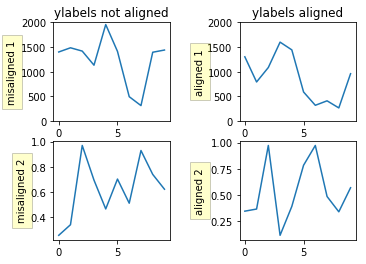

In [9]:
import numpy as np
import matplotlib.pyplot as plt



# Uncomment following line if:
# - you're using Jupyter
# - want to display charts inline
#
%matplotlib inline


box = dict(facecolor='yellow', pad=5, alpha=0.2)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.subplots_adjust(left=0.2, wspace=0.6)

# Fixing random state for reproducibility
np.random.seed(19680801)

ax1.plot(2000*np.random.rand(10))
ax1.set_title('ylabels not aligned')
ax1.set_ylabel('misaligned 1', bbox=box)
ax1.set_ylim(0, 2000)

ax3.set_ylabel('misaligned 2',bbox=box)
ax3.plot(np.random.rand(10))

labelx = -0.3  # axes coords

ax2.set_title('ylabels aligned')
ax2.plot(2000*np.random.rand(10))
ax2.set_ylabel('aligned 1', bbox=box)
ax2.yaxis.set_label_coords(labelx, 0.5)
ax2.set_ylim(0, 2000)

ax4.plot(np.random.rand(10))
ax4.set_ylabel('aligned 2', bbox=box)
ax4.yaxis.set_label_coords(labelx, 0.5)

plt.show()

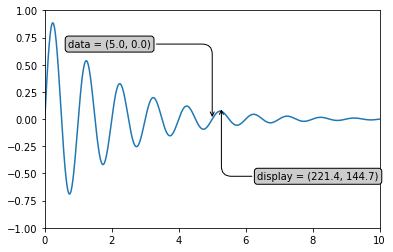

In [10]:
import numpy as np
import matplotlib.pyplot as plt


# Uncomment following line if:
# - you're using Jupyter
# - want to display charts inline
#
%matplotlib inline


x = np.arange(0, 10, 0.005)
y = np.exp(-x/2.) * np.sin(2*np.pi*x)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x, y)
ax.set_xlim(0, 10)
ax.set_ylim(-1, 1)

xdata, ydata = 5, 0
xdisplay, ydisplay = ax.transData.transform_point((xdata, ydata))

bbox = dict(boxstyle="round", fc="0.8")
arrowprops = dict(
    arrowstyle = "->",
    connectionstyle = "angle,angleA=0,angleB=90,rad=10")

offset = 72
ax.annotate('data = (%.1f, %.1f)'%(xdata, ydata),
            (xdata, ydata), xytext=(-2*offset, offset), textcoords='offset points',
            bbox=bbox, arrowprops=arrowprops)


disp = ax.annotate('display = (%.1f, %.1f)'%(xdisplay, ydisplay),
            (xdisplay, ydisplay), xytext=(0.5*offset, -offset),
            xycoords='figure pixels',
            textcoords='offset points',
            bbox=bbox, arrowprops=arrowprops)


plt.show()

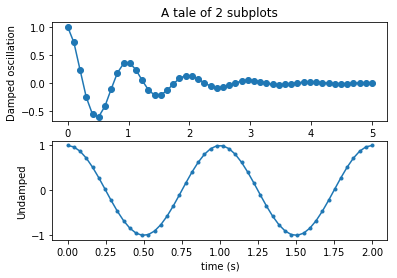

In [11]:
import numpy as np
import matplotlib.pyplot as plt


# Uncomment following line if:
# - you're using Jupyter
# - want to display charts inline
#
%matplotlib inline


x1 = np.linspace(0.0, 5.0)
x2 = np.linspace(0.0, 2.0)

y1 = np.cos(2 * np.pi * x1) * np.exp(-x1)
y2 = np.cos(2 * np.pi * x2)

plt.subplot(2, 1, 1)
plt.plot(x1, y1, 'o-')
plt.title('A tale of 2 subplots')
plt.ylabel('Damped oscillation')

plt.subplot(2, 1, 2)
plt.plot(x2, y2, '.-')
plt.xlabel('time (s)')
plt.ylabel('Undamped')

plt.show()

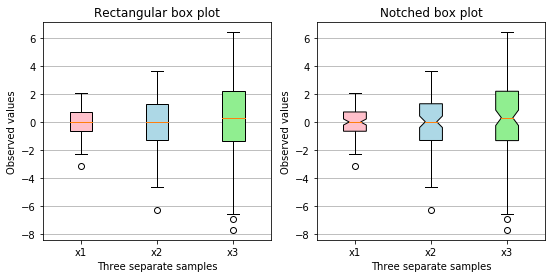

In [12]:
import matplotlib.pyplot as plt
import numpy as np


# Uncomment following line if:
# - you're using Jupyter
# - want to display charts inline
#
%matplotlib inline


# Random test data
np.random.seed(19680801)
all_data = [np.random.normal(0, std, size=100) for std in range(1, 4)]
labels = ['x1', 'x2', 'x3']

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))

# rectangular box plot
bplot1 = axes[0].boxplot(all_data,
                         vert=True,  # vertical box alignment
                         patch_artist=True,  # fill with color
                         labels=labels)  # will be used to label x-ticks
axes[0].set_title('Rectangular box plot')

# notch shape box plot
bplot2 = axes[1].boxplot(all_data,
                         notch=True,  # notch shape
                         vert=True,  # vertical box alignment
                         patch_artist=True,  # fill with color
                         labels=labels)  # will be used to label x-ticks
axes[1].set_title('Notched box plot')

# fill with colors
colors = ['pink', 'lightblue', 'lightgreen']
for bplot in (bplot1, bplot2):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

# adding horizontal grid lines
for ax in axes:
    ax.yaxis.grid(True)
    ax.set_xlabel('Three separate samples')
    ax.set_ylabel('Observed values')

plt.show()

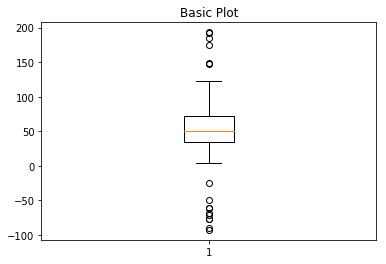

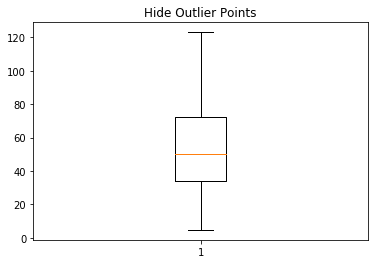

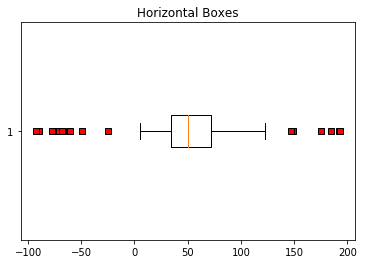

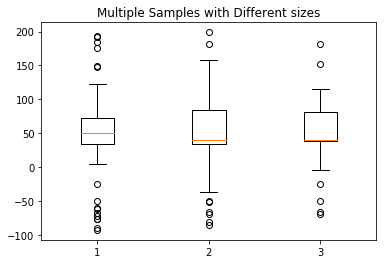

In [18]:
import numpy as np
import matplotlib.pyplot as plt


# Uncomment following line if:
# - you're using Jupyter
# - want to display charts inline
#
%matplotlib inline


# Fixing random state for reproducibility
np.random.seed(19680801)

# fake up some data
spread = np.random.rand(50) * 100
center = np.ones(25) * 50
flier_high = np.random.rand(10) * 100 + 100
flier_low = np.random.rand(10) * -100
data = np.concatenate((spread, center, flier_high, flier_low), 0)

fig1, ax1 = plt.subplots()
ax1.set_title('Basic Plot')
ax1.boxplot(data)

fig4, ax4 = plt.subplots()
ax4.set_title('Hide Outlier Points')
ax4.boxplot(data, showfliers=False)

red_square = dict(markerfacecolor='r', marker='s')
fig5, ax5 = plt.subplots()
ax5.set_title('Horizontal Boxes')
ax5.boxplot(data, vert=False, flierprops=red_square)




spread = np.random.rand(50) * 100
center = np.ones(25) * 40
flier_high = np.random.rand(10) * 100 + 100
flier_low = np.random.rand(10) * -100
d2 = np.concatenate((spread, center, flier_high, flier_low), 0)
data.shape = (-1, 1)
d2.shape = (-1, 1)

data = [data, d2, d2[::2,0]]
fig7, ax7 = plt.subplots()
ax7.set_title('Multiple Samples with Different sizes')
ax7.boxplot(data)

plt.show()

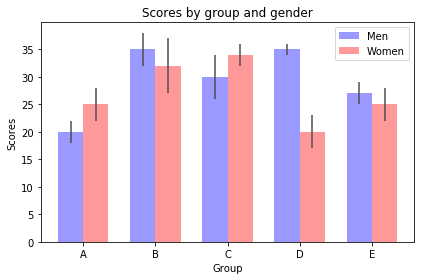

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from collections import namedtuple


n_groups = 5

means_men = (20, 35, 30, 35, 27)
std_men = (2, 3, 4, 1, 2)

means_women = (25, 32, 34, 20, 25)
std_women = (3, 5, 2, 3, 3)

fig, ax = plt.subplots()

index = np.arange(n_groups)
bar_width = 0.35

opacity = 0.4
error_config = {'ecolor': '0.3'}

rects1 = ax.bar(index, means_men, bar_width,
                alpha=opacity, color='b',
                yerr=std_men, error_kw=error_config,
                label='Men')

rects2 = ax.bar(index + bar_width, means_women, bar_width,
                alpha=opacity, color='r',
                yerr=std_women, error_kw=error_config,
                label='Women')

ax.set_xlabel('Group')
ax.set_ylabel('Scores')
ax.set_title('Scores by group and gender')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(('A', 'B', 'C', 'D', 'E'))
ax.legend()

fig.tight_layout()
plt.show()

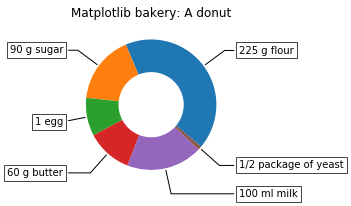

In [20]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 3), subplot_kw=dict(aspect="equal"))

recipe = ["225 g flour",
          "90 g sugar",
          "1 egg",
          "60 g butter",
          "100 ml milk",
          "1/2 package of yeast"]

data = [225, 90, 50, 60, 100, 5]

wedges, texts = ax.pie(data, wedgeprops=dict(width=0.5), startangle=-40)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(xycoords='data', textcoords='data', arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(recipe[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                 horizontalalignment=horizontalalignment, **kw)

ax.set_title("Matplotlib bakery: A donut")

plt.show()

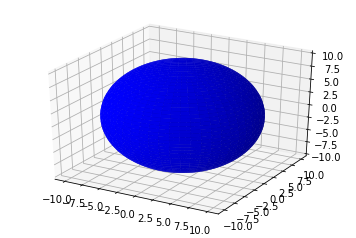

In [21]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Make data
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x = 10 * np.outer(np.cos(u), np.sin(v))
y = 10 * np.outer(np.sin(u), np.sin(v))
z = 10 * np.outer(np.ones(np.size(u)), np.cos(v))

# Plot the surface
ax.plot_surface(x, y, z, color='b')

plt.show()


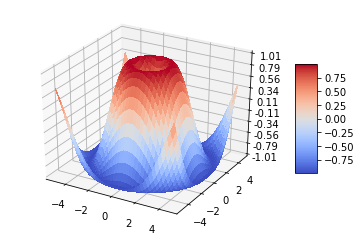

In [22]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np


fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
X = np.arange(-5, 5, 0.25)
Y = np.arange(-5, 5, 0.25)
X, Y = np.meshgrid(X, Y)
R = np.sqrt(X**2 + Y**2)
Z = np.sin(R)

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

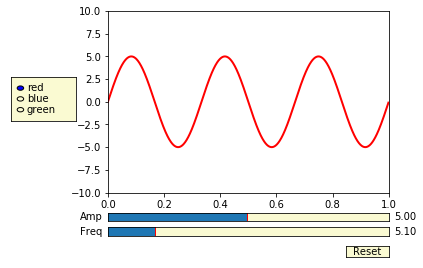

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, RadioButtons

fig, ax = plt.subplots()
plt.subplots_adjust(left=0.25, bottom=0.25)
t = np.arange(0.0, 1.0, 0.001)
a0 = 5
f0 = 3
delta_f = 5.0
s = a0*np.sin(2*np.pi*f0*t)
l, = plt.plot(t, s, lw=2, color='red')
plt.axis([0, 1, -10, 10])

axcolor = 'lightgoldenrodyellow'
axfreq = plt.axes([0.25, 0.1, 0.65, 0.03], facecolor=axcolor)
axamp = plt.axes([0.25, 0.15, 0.65, 0.03], facecolor=axcolor)

sfreq = Slider(axfreq, 'Freq', 0.1, 30.0, valinit=f0, valstep=delta_f)
samp = Slider(axamp, 'Amp', 0.1, 10.0, valinit=a0)


def update(val):
    amp = samp.val
    freq = sfreq.val
    l.set_ydata(amp*np.sin(2*np.pi*freq*t))
    fig.canvas.draw_idle()
sfreq.on_changed(update)
samp.on_changed(update)

resetax = plt.axes([0.8, 0.025, 0.1, 0.04])
button = Button(resetax, 'Reset', color=axcolor, hovercolor='0.975')


def reset(event):
    sfreq.reset()
    samp.reset()
button.on_clicked(reset)

rax = plt.axes([0.025, 0.5, 0.15, 0.15], facecolor=axcolor)
radio = RadioButtons(rax, ('red', 'blue', 'green'), active=0)


def colorfunc(label):
    l.set_color(label)
    fig.canvas.draw_idle()
radio.on_clicked(colorfunc)

plt.show()
